In [1]:
import pandas as pd
import numpy as np

In [2]:
# --- Step 1: Load all 9 CSV files ---
print("Step 1: Loading all 9 CSV files...")
df_orders = pd.read_csv("olist_orders_dataset.csv")
df_reviews = pd.read_csv("olist_order_reviews_dataset.csv")
df_items = pd.read_csv("olist_order_items_dataset.csv")
df_payments = pd.read_csv("olist_order_payments_dataset.csv")
df_products = pd.read_csv("olist_products_dataset.csv")
df_sellers = pd.read_csv("olist_sellers_dataset.csv")
df_customers = pd.read_csv("olist_customers_dataset.csv")
df_geo = pd.read_csv("olist_geolocation_dataset.csv")
df_translation = pd.read_csv("product_category_name_translation.csv")
print("All files loaded successfully.")

Step 1: Loading all 9 CSV files...
All files loaded successfully.


In [3]:
# --- Step 2: Aggregate Payments ---
# An order can have multiple payment methods (e.g., voucher + credit_card).
# We'll aggregate them to the order level.
print("\nStep 2: Processing Payments...")
# Find the most common payment type for each order
df_payment_type = df_payments.loc[df_payments.groupby('order_id')['payment_sequential'].idxmax()][['order_id', 'payment_type']]

# Aggregate payment data
df_payments_agg = df_payments.groupby('order_id').agg(
    total_payment_value=('payment_value', 'sum'),
    total_payment_installments=('payment_installments', 'sum'),
    num_payment_methods=('payment_sequential', 'max')
).reset_index()

# Merge the most common payment type
df_payments_agg = pd.merge(df_payments_agg, df_payment_type, on='order_id', how='left')


Step 2: Processing Payments...


In [4]:
# --- Step 3: Aggregate Items/Products/Sellers ---
print("\nStep 3: Processing Items, Products, and Sellers...")

# 3a. Merge products with their English translation
df_products_translated = pd.merge(df_products, df_translation, on='product_category_name', how='left')

# 3b. Merge items with product and seller info
df_items_full = pd.merge(df_items, df_products_translated, on='product_id', how='left')
df_items_full = pd.merge(df_items_full, df_sellers, on='seller_id', how='left')

# 3c. Create product volume feature
df_items_full['product_volume_cm3'] = df_items_full['product_length_cm'] * df_items_full['product_height_cm'] * df_items_full['product_width_cm']

# 3d. Aggregate item/product data by order_id
df_items_agg = df_items_full.groupby('order_id').agg(
    total_price=('price', 'sum'),
    total_freight_value=('freight_value', 'sum'),
    num_items=('order_item_id', 'count'),
    avg_product_weight_g=('product_weight_g', 'mean'),
    avg_product_volume_cm3=('product_volume_cm3', 'mean'),
    num_sellers=('seller_id', 'nunique'),
    avg_photos_qty=('product_photos_qty', 'mean'),
    avg_product_name_length=('product_name_lenght', 'mean'),
    avg_product_description_length=('product_description_lenght', 'mean')
).reset_index()

# 3e. Get location of the *first* seller for each order (for distance calculation)
df_seller_location = df_items_full.loc[df_items_full['order_item_id'] == 1][[
    'order_id',
    'seller_zip_code_prefix',
    'seller_state'
]]


Step 3: Processing Items, Products, and Sellers...


In [5]:
# --- Step 4: Pre-process Geolocation ---
# The geo file has ~1M rows but only ~19K unique zip codes.
# We'll create one average lat/lng for each zip code prefix.
print("\nStep 4: Processing Geolocation data...")
df_geo_agg = df_geo.groupby('geolocation_zip_code_prefix').agg(
    geo_lat=('geolocation_lat', 'mean'),
    geo_lng=('geolocation_lng', 'mean')
).reset_index()
print(f"Geolocation data reduced from {len(df_geo)} to {len(df_geo_agg)} unique zip codes.")


Step 4: Processing Geolocation data...
Geolocation data reduced from 1000163 to 19015 unique zip codes.


In [6]:
# --- Step 5: Build Master Table ---
print("\nStep 5: Building Master Table...")

# 5a. Start with the 'orders' table.
# We'll filter for 'delivered' orders, as they are the only ones with a complete lifecycle.
df_master = df_orders[df_orders['order_status'] == 'delivered'].copy()
print(f"Started with {len(df_orders)} orders, filtered to {len(df_master)} 'delivered' orders.")

# 5b. Merge with reviews. We use 'inner' join to keep only orders that have a review.
# The review_score is our target variable (y).
df_master = pd.merge(df_master, df_reviews[['order_id', 'review_score']], on='order_id', how='inner')

# 5c. Merge with customer info
df_master = pd.merge(df_master, df_customers[['customer_id', 'customer_unique_id', 'customer_zip_code_prefix', 'customer_city', 'customer_state']], on='customer_id', how='left')

# 5d. Merge with aggregated payments
df_master = pd.merge(df_master, df_payments_agg, on='order_id', how='left')

# 5e. Merge with aggregated items
df_master = pd.merge(df_master, df_items_agg, on='order_id', how='left')

# 5f. Merge with the first-seller location info
df_master = pd.merge(df_master, df_seller_location, on='order_id', how='left')
print(f"Master table created with {len(df_master)} rows.")


Step 5: Building Master Table...
Started with 99441 orders, filtered to 96478 'delivered' orders.
Master table created with 96361 rows.


In [7]:
# --- Step 6: Feature Engineering ---
print("\nStep 6: Feature Engineering...")

# 6a. Convert timestamp columns to datetime objects
time_cols = [
    'order_purchase_timestamp',
    'order_approved_at',
    'order_delivered_carrier_date',
    'order_delivered_customer_date',
    'order_estimated_delivery_date'
]
for col in time_cols:
    df_master[col] = pd.to_datetime(df_master[col])

# 6b. Create time-based features (in days)
df_master['delivery_time_days'] = (df_master['order_delivered_customer_date'] - df_master['order_purchase_timestamp']).dt.total_seconds() / (24 * 60 * 60)
df_master['estimated_delivery_time_days'] = (df_master['order_estimated_delivery_date'] - df_master['order_purchase_timestamp']).dt.total_seconds() / (24 * 60 * 60)
df_master['shipping_time_days'] = (df_master['order_delivered_customer_date'] - df_master['order_delivered_carrier_date']).dt.total_seconds() / (24 * 60 * 60)
df_master['approval_time_days'] = (df_master['order_approved_at'] - df_master['order_purchase_timestamp']).dt.total_seconds() / (24 * 60 * 60)
df_master['days_to_ship'] = (df_master['order_delivered_carrier_date'] - df_master['order_approved_at']).dt.total_seconds() / (24 * 60 * 60)

# 6c. Create 'is_late' feature
df_master['is_late'] = (df_master['order_delivered_customer_date'] > df_master['order_estimated_delivery_date']).astype(int)

# 6d. Create 'freight_ratio' feature
df_master['freight_ratio'] = df_master['total_freight_value'] / df_master['total_price']
# Replace any infinite values (if price was 0) with 0
df_master['freight_ratio'].replace([np.inf, -np.inf], 0, inplace=True)


# 6e. Extract temporal features from purchase timestamp
df_master['purchase_day_of_week'] = df_master['order_purchase_timestamp'].dt.dayofweek
df_master['purchase_month'] = df_master['order_purchase_timestamp'].dt.month
df_master['purchase_hour'] = df_master['order_purchase_timestamp'].dt.hour


Step 6: Feature Engineering...


/tmp/ipython-input-229972021.py:28: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_master['freight_ratio'].replace([np.inf, -np.inf], 0, inplace=True)


In [8]:
# --- Step 7: Calculate Seller-Customer Distance ---
print("\nStep 7: Calculating Seller-Customer Distance...")

# 7a. Merge with geo data for customer
df_master = pd.merge(
    df_master,
    df_geo_agg,
    left_on='customer_zip_code_prefix',
    right_on='geolocation_zip_code_prefix',
    how='left'
)
df_master.rename(columns={'geo_lat': 'customer_lat', 'geo_lng': 'customer_lng'}, inplace=True)
df_master.drop('geolocation_zip_code_prefix', axis=1, inplace=True)

# 7b. Merge with geo data for seller
df_master = pd.merge(
    df_master,
    df_geo_agg,
    left_on='seller_zip_code_prefix',
    right_on='geolocation_zip_code_prefix',
    how='left'
)
df_master.rename(columns={'geo_lat': 'seller_lat', 'geo_lng': 'seller_lng'}, inplace=True)
df_master.drop('geolocation_zip_code_prefix', axis=1, inplace=True)

# 7c. Define Haversine function to calculate distance in km
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Earth radius in kilometers

    # Check for NaNs before conversion
    if any(pd.isna([lat1, lon1, lat2, lon2])):
        return np.nan

    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))

    distance = R * c
    return distance

# 7d. Calculate distance
# Note: .apply() can be slow. A vectorized numpy approach is faster,
# but this is more readable and matches the logic used.
print("Calculating Haversine distance (this may take a minute)...")
df_master['seller_customer_distance_km'] = df_master.apply(
    lambda row: haversine(
        row['customer_lat'],
        row['customer_lng'],
        row['seller_lat'],
        row['seller_lng']
    ),
    axis=1
)
print("Distance calculation complete.")


Step 7: Calculating Seller-Customer Distance...
Calculating Haversine distance (this may take a minute)...
Distance calculation complete.


In [9]:
# --- Step 8: Final Cleanup and Preprocessing ---
print("\nStep 8: Final Cleanup and Preprocessing...")

# 8a. Select columns for the final ML dataset
target_col = 'review_score'

numeric_features = [
    'total_payment_value', 'total_payment_installments', 'num_payment_methods',
    'total_price', 'total_freight_value', 'num_items',
    'avg_product_weight_g', 'avg_product_volume_cm3', 'num_sellers',
    'avg_photos_qty', 'avg_product_name_length', 'avg_product_description_length',
    'delivery_time_days', 'estimated_delivery_time_days', 'shipping_time_days',
    'approval_time_days', 'days_to_ship', 'is_late', 'freight_ratio',
    'purchase_day_of_week', 'purchase_month', 'purchase_hour',
    'seller_customer_distance_km'
]

categorical_features = ['payment_type', 'customer_state', 'seller_state']

columns_to_keep = [target_col] + numeric_features + categorical_features
df_ml = df_master[columns_to_keep].copy()
print(f"Kept {len(df_ml.columns)} columns for the final dataset.")

# 8b. Handle Missing Values
print("Handling missing values...")

# For numeric features, fill with the median
for col in numeric_features:
    if df_ml[col].isnull().any():
        median_val = df_ml[col].median()
        df_ml[col].fillna(median_val, inplace=True)

# For categorical features, fill with 'unknown'
for col in categorical_features:
    if df_ml[col].isnull().any():
        df_ml[col].fillna('unknown', inplace=True)

# 8c. One-Hot Encode Categorical Features
print("One-hot encoding categorical features...")
df_ml = pd.get_dummies(df_ml, columns=categorical_features, drop_first=True)
print(f"Dataset shape after one-hot encoding: {df_ml.shape}")


Step 8: Final Cleanup and Preprocessing...
Kept 27 columns for the final dataset.
Handling missing values...
One-hot encoding categorical features...
Dataset shape after one-hot encoding: (96361, 75)


/tmp/ipython-input-2060407349.py:31: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_ml[col].fillna(median_val, inplace=True)
/tmp/ipython-input-2060407349.py:36: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using

In [10]:
# 8d. Final check
print(f"Total remaining NaN values: {df_ml.isnull().sum().sum()}")

Total remaining NaN values: 0


In [11]:
# 8e. Save the final dataset
print("\nSaving the final ML-ready dataset to 'final_ml_dataset.csv'...")
df_ml.to_csv('final_ml_dataset.csv', index=False)

print("\n--- All Done! 'final_ml_dataset.csv' is ready. ---")


Saving the final ML-ready dataset to 'final_ml_dataset.csv'...

--- All Done! 'final_ml_dataset.csv' is ready. ---


# EDA and Visualizations (enhanced)



In [12]:

# ===== IMPORTS & DATALOAD =====
# Add markdown above describing what datasets we load and why.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta

# Increase max rows display if desired (optional)
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 100)

# Load datasets (only load needed columns to save memory where appropriate)
customers = pd.read_csv(f"olist_customers_dataset.csv")
orders = pd.read_csv(f"olist_orders_dataset.csv", parse_dates=['order_purchase_timestamp','order_approved_at','order_delivered_customer_date','order_estimated_delivery_date'], low_memory=False)
order_items = pd.read_csv(f"olist_order_items_dataset.csv", parse_dates=['shipping_limit_date'], low_memory=False)
payments = pd.read_csv(f"olist_order_payments_dataset.csv", low_memory=False)
reviews = pd.read_csv(f"olist_order_reviews_dataset.csv", parse_dates=['review_creation_date','review_answer_timestamp'], low_memory=False)
products = pd.read_csv(f"olist_products_dataset.csv", low_memory=False)
sellers = pd.read_csv(f"olist_sellers_dataset.csv", low_memory=False)
categories = pd.read_csv(f"product_category_name_translation.csv", low_memory=False)
geoloc = pd.read_csv(f"olist_geolocation_dataset.csv", low_memory=False)

print('Loaded: customers', customers.shape, 'orders', orders.shape, 'order_items', order_items.shape)


Loaded: customers (99441, 5) orders (99441, 8) order_items (112650, 7)


##  Dataset inventory & objectives

**What we're loading:** this notebook loads the primary Olist tables: customers, orders, order_items, payments, reviews, products, sellers, category translations and geolocation.  

**Primary objectives:**
- Provide an initial exploratory data analysis (EDA) across orders, delivery performance, payments and reviews.
- Identify data quality issues and propose next steps.
- Surface top product categories by revenue and highlight seller performance signals.

**Inference (quick):** The dataset is comprehensive and enables linking orders to products, payments and reviews. Be mindful of large joins (geolocation ~1M rows).

In [13]:

# ===== MISSING VALUES & DTYPES =====
# PLACEHOLDER: Add markdown summarizing the missing-values check and main takeaways.
def missing_report(df):
    miss = df.isna().sum()
    pct = (miss / len(df) * 100).round(3)
    return pd.DataFrame({'missing_count': miss, 'missing_pct': pct}).sort_values('missing_count', ascending=False)

print('\n-- orders missing values --')
display(missing_report(orders).head(20))
print('\n-- order_items missing values --')
display(missing_report(order_items).head(20))
print('\n-- products missing values --')
display(missing_report(products).head(20))
print('\n-- reviews missing values --')
display(missing_report(reviews).head(20))



-- orders missing values --


,missing_count,missing_pct
order_delivered_customer_date,2965,2.982
order_delivered_carrier_date,1783,1.793
order_approved_at,160,0.161
order_id,0,0.000
order_purchase_timestamp,0,0.000
order_status,0,0.000
customer_id,0,0.000
order_estimated_delivery_date,0,0.000



-- order_items missing values --


,missing_count,missing_pct
order_id,0,0.0
order_item_id,0,0.0
product_id,0,0.0
seller_id,0,0.0
shipping_limit_date,0,0.0
price,0,0.0
freight_value,0,0.0



-- products missing values --


,missing_count,missing_pct
product_category_name,610,1.851
product_description_lenght,610,1.851
product_name_lenght,610,1.851
product_photos_qty,610,1.851
product_weight_g,2,0.006
product_height_cm,2,0.006
product_length_cm,2,0.006
product_width_cm,2,0.006
product_id,0,0.000



-- reviews missing values --


,missing_count,missing_pct
review_comment_title,87656,88.342
review_comment_message,58247,58.703
review_id,0,0.000
review_score,0,0.000
order_id,0,0.000
review_creation_date,0,0.000
review_answer_timestamp,0,0.000


##  Missing values — summary and handling

The table above lists columns with missing values and their percentages.  

**Key takeaways:**
- Missingness in timestamp fields (e.g., `order_delivered_customer_date`) is expected for orders not yet delivered and should be handled carefully when computing delivery metrics.
- Missing categorical fields in product or geolocation tables (if any) may require imputation or record-level exclusion depending on the analysis.

**Suggested handling:**
- For delivery-time analyses: restrict to records with both purchase and delivered timestamps.
- For joins with geolocation: reduce the geolocation table to one coordinate per zip prefix first to avoid many-to-many blowups.

In [14]:

# ===== BASIC DESCRIPTIVE STATS =====
# PLACEHOLDER: Add markdown with inferences (e.g., which tables are largest, any surprising missingness).
print('Unique customers:', customers['customer_unique_id'].nunique())
print('Unique orders:', orders['order_id'].nunique())
print('Unique products:', products['product_id'].nunique())

# Orders over time (monthly)
orders['order_month'] = orders['order_purchase_timestamp'].dt.to_period('M')
monthly = orders.groupby('order_month').size().rename('n_orders').reset_index()
monthly['order_month'] = monthly['order_month'].dt.to_timestamp()

display(monthly.head())


Unique customers: 96096
Unique orders: 99441
Unique products: 32951


,order_month,n_orders
0,2016-09-01,4
1,2016-10-01,324
2,2016-12-01,1
3,2017-01-01,800
4,2017-02-01,1780


##  High-level descriptive statistics & initial observations

This section shows counts of unique customers, orders and products and a monthly orders time series.  

**Inference:**
- The dataset contains a large number of unique customers and orders — suitable for aggregate and cohort analyses.
- Use the orders-per-month series to identify seasonality or special events that may affect demand (holiday spikes, promotions).

**Next steps:** annotate months with spikes and investigate which categories or sellers drove those spikes.

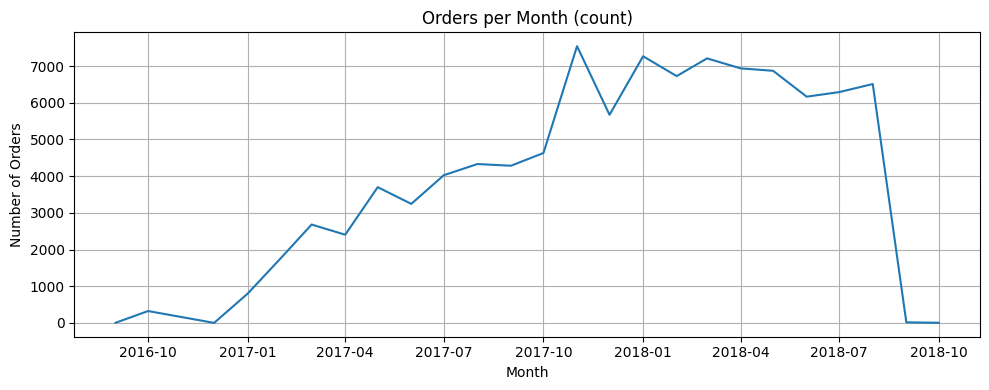

In [15]:

# ===== ORDERS OVER TIME =====
# PLACEHOLDER: Add markdown interpreting the time series (seasonality, trends, spikes)
plt.figure(figsize=(10,4))
plt.plot(monthly['order_month'], monthly['n_orders'])
plt.title('Orders per Month (count)')
plt.xlabel('Month')
plt.ylabel('Number of Orders')
plt.grid(True)
plt.tight_layout()
plt.show()


##  Orders over time — interpretation

The line chart shows monthly order volume.  

**Inference:** Look for upward/downward trends and recurring seasonal patterns. If clear spikes exist, annotate them with dates and cross-check marketing or macro events.

**Actionable idea:** compute year-over-year growth for matching months to quantify seasonality.

delivery_time_days: mean, median, std -> 12.558702304032053 10.21775462962963 9.546529874135537


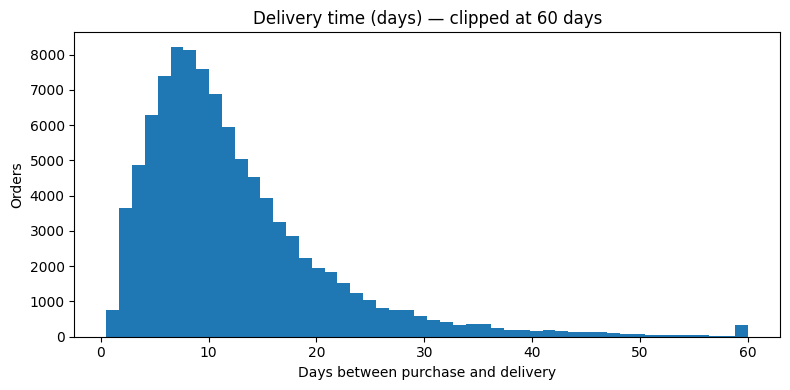

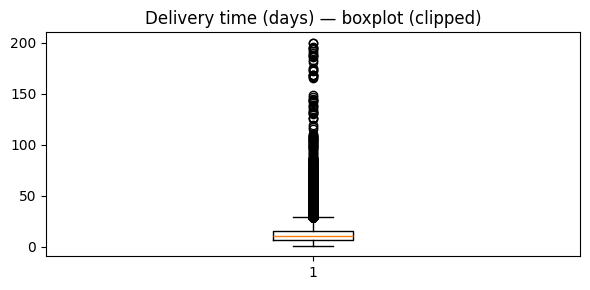

In [16]:

# ===== DELIVERY TIMES =====
# Compute delivery time: delivered_customer_date - purchase_timestamp (in days)
# We'll drop rows without delivered date
orders_dt = orders.copy()
orders_dt = orders_dt[orders_dt['order_delivered_customer_date'].notna() & orders_dt['order_purchase_timestamp'].notna()].copy()
orders_dt['delivery_time_days'] = (orders_dt['order_delivered_customer_date'] - orders_dt['order_purchase_timestamp']).dt.total_seconds() / (3600*24)
print('delivery_time_days: mean, median, std ->', orders_dt['delivery_time_days'].mean(), orders_dt['delivery_time_days'].median(), orders_dt['delivery_time_days'].std())

# Histogram
plt.figure(figsize=(8,4))
plt.hist(orders_dt['delivery_time_days'].clip(upper=60), bins=50)
plt.title('Delivery time (days) — clipped at 60 days')
plt.xlabel('Days between purchase and delivery')
plt.ylabel('Orders')
plt.tight_layout()
plt.show()

# Boxplot (to show outliers)
plt.figure(figsize=(6,3))
plt.boxplot(orders_dt['delivery_time_days'].dropna().clip(upper=200))
plt.title('Delivery time (days) — boxplot (clipped)')
plt.tight_layout()
plt.show()


##  Delivery time distribution — interpretation

We computed `delivery_time_days` as delivered date minus purchase date and plotted both a histogram and boxplot.  

**Inference:**
- The mean vs median indicates whether the distribution is skewed; long tails often indicate outliers or exceptional delays.
- Clipping the histogram helps visualize the bulk of the distribution — but keep the full distribution for outlier investigation.

**Next steps:**
- Investigate orders with extremely high delivery times (e.g., > 60 days): examine seller, product, and geographic patterns.
- Consider computing delivery SLA breach rates by seller or region.

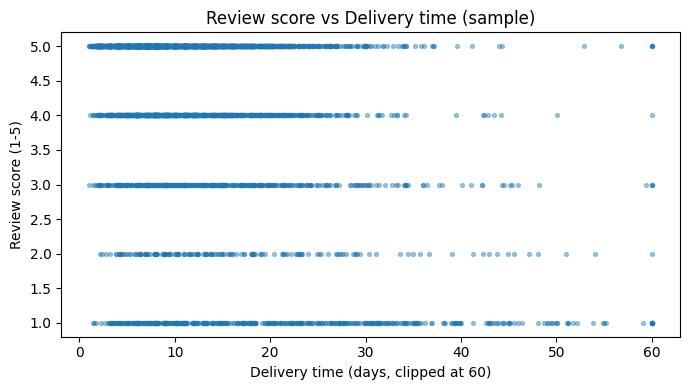

/tmp/ipython-input-2701985503.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_by_bin = rev_ord.groupby('deliv_bin')['review_score'].mean().reset_index()


,deliv_bin,review_score
0,"(0, 2]",4.493375
1,"(2, 5]",4.441564
2,"(5, 10]",4.362013
3,"(10, 20]",4.218858
4,"(20, 60]",3.257143
5,"(60, 200]",2.140893


In [17]:

# ===== REVIEWS vs DELIVERY TIME =====
# Merge reviews with orders delivery time and analyze relationship between delivery delays and review score.
rev_ord = reviews.merge(orders_dt[['order_id','delivery_time_days']], on='order_id', how='left')
# simple scatter sample (random sample for plotting performance)
sample = rev_ord.sample(n=5000, random_state=42) if len(rev_ord)>5000 else rev_ord
plt.figure(figsize=(7,4))
plt.scatter(sample['delivery_time_days'].clip(upper=60), sample['review_score'], alpha=0.4, s=8)
plt.xlabel('Delivery time (days, clipped at 60)')
plt.ylabel('Review score (1-5)')
plt.title('Review score vs Delivery time (sample)')
plt.tight_layout()
plt.show()

# Aggregated view: average review score by binned delivery time
bins = [0,2,5,10,20,60,200]
rev_ord['deliv_bin'] = pd.cut(rev_ord['delivery_time_days'], bins=bins)
avg_by_bin = rev_ord.groupby('deliv_bin')['review_score'].mean().reset_index()
display(avg_by_bin)


Basic stats on (items + freight) - payments_total:


,diff
count,98665.000000
mean,-0.029092
std,1.129221
min,-182.810000
25%,0.000000
50%,0.000000
75%,0.000000
max,51.620000


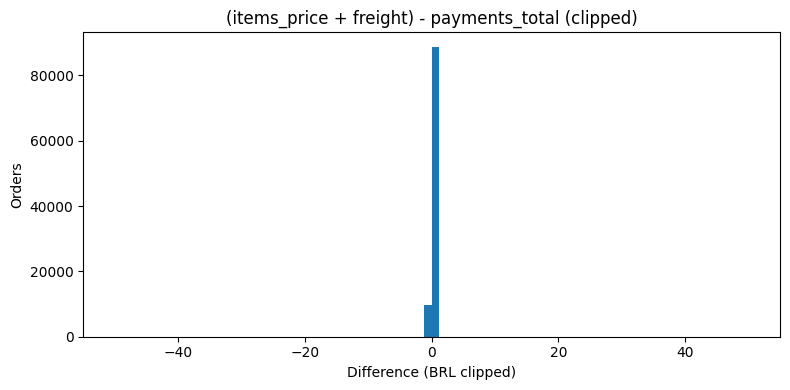

In [18]:

# ===== PRICE, FREIGHT & PAYMENTS =====
# Sum of order_items.price per order vs payments.payment_value
order_items_sum = order_items.groupby('order_id').agg({'price':'sum','freight_value':'sum'}).rename(columns={'price':'items_price','freight_value':'items_freight'}).reset_index()
payments_sum = payments.groupby('order_id')['payment_value'].sum().reset_index().rename(columns={'payment_value':'payments_total'})

# Merge and compare
order_pay_compare = order_items_sum.merge(payments_sum, on='order_id', how='left')
order_pay_compare['diff'] = order_pay_compare['items_price'] + order_pay_compare['items_freight'] - order_pay_compare['payments_total']
print('Basic stats on (items + freight) - payments_total:')
display(order_pay_compare['diff'].describe())

# Plot distribution of diff (clip for visibility)
plt.figure(figsize=(8,4))
plt.hist(order_pay_compare['diff'].dropna().clip(-50,50), bins=80)
plt.title('(items_price + freight) - payments_total (clipped)')
plt.xlabel('Difference (BRL clipped)')
plt.ylabel('Orders')
plt.tight_layout()
plt.show()


##  Payment reconciliation: items + freight vs payments

This compares the sum of item prices plus freight to recorded payment totals.  

**Inference:**
- Small numerical differences are possible (rounding, multiple payments), but large discrepancies require data-quality checks.
- Negative diffs indicate payments larger than item+freight; positive diffs indicate underpayment or missing fees.

**Next steps:**
- Flag orders with absolute diffs above a threshold (e.g., > 1 BRL) for manual inspection.
- Reconcile by payment types and installments to understand patterns.

,product_category_name_english,price
43,health_beauty,1258681.34
70,watches_gifts,1205005.68
7,bed_bath_table,1036988.68
65,sports_leisure,988048.97
15,computers_accessories,911954.32
39,furniture_decor,729762.49
20,cool_stuff,635290.85
49,housewares,632248.66
5,auto,592720.11
42,garden_tools,485256.46


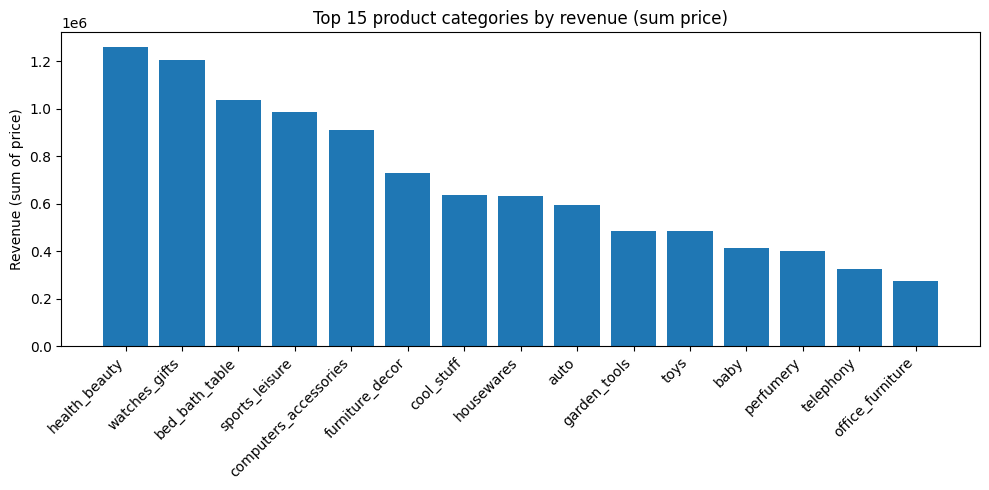

In [19]:

# ===== TOP CATEGORIES BY REVENUE =====
# Merge products -> categories -> order_items
prod_cat = products.merge(categories, on='product_category_name', how='left')
oi_prod = order_items.merge(prod_cat[['product_id','product_category_name_english']], on='product_id', how='left')
cat_revenue = oi_prod.groupby('product_category_name_english')['price'].sum().reset_index().sort_values('price', ascending=False).head(15)
display(cat_revenue)

# Bar plot
plt.figure(figsize=(10,5))
plt.bar(cat_revenue['product_category_name_english'].astype(str), cat_revenue['price'])
plt.xticks(rotation=45, ha='right')
plt.title('Top 15 product categories by revenue (sum price)')
plt.ylabel('Revenue (sum of price)')
plt.tight_layout()
plt.show()


##  Top product categories by revenue — interpretation

We aggregated revenue by translated product category names and plotted the top 15.  

**Inference:**
- Categories at the top are revenue drivers — investigate inventory, returns, and margins for these categories.
- Be careful: `price` in the dataset may not include discounts or promotions.

**Next steps:**
- Compute average order value and return rates per category, and compare against category-level marketing spend if available.

Reduced geolocation rows: (19015, 3)
Distance stats (km):


,distance_km
count,1997.000000
mean,593.765473
std,588.126631
min,0.000000
25%,194.003775
50%,423.508075
75%,778.594550
max,3304.724568


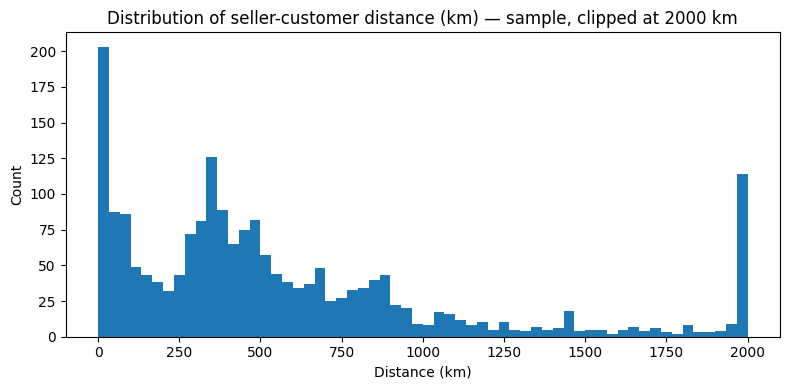

In [20]:

# ===== GEOLOCATION & DISTANCES =====
# Reduce geolocation to one centroid lat/lng per zip code prefix (median to reduce noise)
geo_red = geoloc.groupby('geolocation_zip_code_prefix').agg({'geolocation_lat':'median','geolocation_lng':'median'}).reset_index().rename(columns={'geolocation_zip_code_prefix':'zip_code_prefix'})
print('Reduced geolocation rows:', geo_red.shape)

# Try to merge seller/customer zip to get distances between seller and customer (on a sample to avoid heavy joins)
# First, map customer and seller zip prefixes (note: customers and sellers have columns with zip code prefixes)
# Prepare mapping
cust_zip = customers[['customer_id','customer_zip_code_prefix']]
seller_zip = sellers[['seller_id','seller_zip_code_prefix']]

# Merge one order -> get seller & customer (this is a sample join; for full-run consider optimized approach)
sample_orders = order_items[['order_id','seller_id']].drop_duplicates().merge(orders[['order_id','customer_id']], on='order_id', how='left').sample(n=2000, random_state=42)
sample_orders = sample_orders.merge(cust_zip, on='customer_id', how='left').merge(seller_zip, on='seller_id', how='left')
sample_orders = sample_orders.merge(geo_red, left_on='customer_zip_code_prefix', right_on='zip_code_prefix', how='left').rename(columns={'geolocation_lat':'cust_lat','geolocation_lng':'cust_lng'})
sample_orders = sample_orders.merge(geo_red, left_on='seller_zip_code_prefix', right_on='zip_code_prefix', how='left', suffixes=('','_seller')).rename(columns={'geolocation_lat':'seller_lat','geolocation_lng':'seller_lng'})

# Define a simple haversine if not present
import math
def haversine_np(lat1, lon1, lat2, lon2):
    # all args arrays or scalars in degrees
    R = 6371.0  # km
    phi1 = np.radians(lat1); phi2 = np.radians(lat2)
    dphi = np.radians(lat2 - lat1); dlambda = np.radians(lon2 - lon1)
    a = np.sin(dphi/2.0)**2 + np.cos(phi1)*np.cos(phi2)*np.sin(dlambda/2.0)**2
    return 2 * R * np.arcsin(np.sqrt(a))

# Compute distance where coords available
mask = sample_orders['cust_lat'].notna() & sample_orders['seller_lat'].notna()
sample_orders['distance_km'] = np.nan
sample_orders.loc[mask, 'distance_km'] = haversine_np(sample_orders.loc[mask,'cust_lat'].astype(float), sample_orders.loc[mask,'cust_lng'].astype(float), sample_orders.loc[mask,'seller_lat'].astype(float), sample_orders.loc[mask,'seller_lng'].astype(float))

print('Distance stats (km):')
display(sample_orders['distance_km'].describe())

plt.figure(figsize=(8,4))
plt.hist(sample_orders['distance_km'].dropna().clip(upper=2000), bins=60)
plt.title('Distribution of seller-customer distance (km) — sample, clipped at 2000 km')
plt.xlabel('Distance (km)')
plt.ylabel('Count')
plt.tight_layout()
plt.show()


## Geolocation & distance analysis — caveats and findings

We reduced the geolocation dataset to median coordinates per zip prefix and computed sample distances between sellers and customers.  

**Inference & caveats:**
- Zip-code-level coordinates are coarse — distances are approximate and can be misleading in large urban areas.
- Missing coordinates reduce sample size; consider enriching with external geocoding if higher precision is required.

**Next steps:**
- Use distances together with delivery times to detect anomalies (e.g., long deliveries for short distances may indicate logistics issues).

,seller_id,delivery_time_days,review_score
2950,ff4ea69c2a729e83e63c7579e4ef8170,9.298605,5.0
2928,fe19dce63ae80346207c6c55713d1023,7.001238,5.0
2927,fdf736c18c589ed030e058312203e1b2,5.490984,5.0
2923,fd435faa3c0422b60440ea3480d0e77c,9.468484,5.0
2921,fd312b6bf05efac6c3772d5b52205d8a,6.378287,5.0
27,028872bfa080090a9d0abd4f1af168f8,16.481273,5.0
21,01ed254b9ff8407dfb9d99ba1e17d923,5.077801,5.0
2915,fc908879b9ca1bd65419e54e50432d38,8.588733,5.0
2910,fc4751cfe3b279c419615b9b00c1abb4,8.010012,5.0
2908,fc0b214b59a83615fea981c6424a02ae,4.384398,5.0


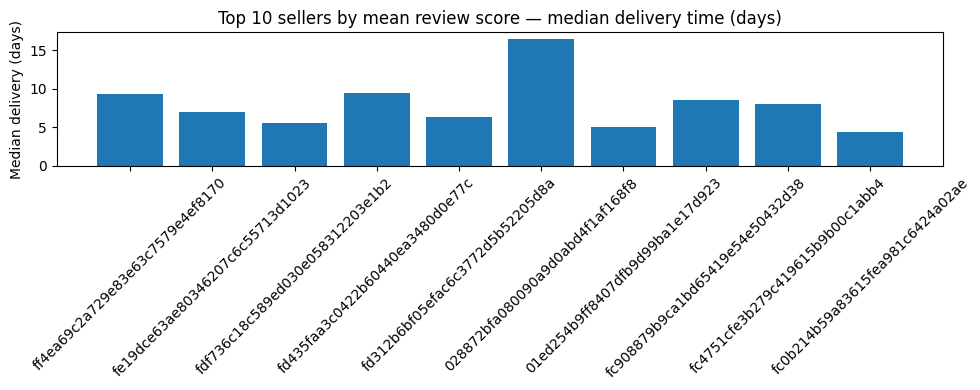

In [21]:

# ===== SELLER PERFORMANCE =====
# Compute average delivery_time and mean review score per seller (join orders->order_items->reviews)
# First map order -> seller (use first seller per order if multiple)
order_seller = order_items.groupby('order_id')['seller_id'].first().reset_index()
orders_seller = orders_dt.merge(order_seller, on='order_id', how='left')
# Merge reviews score to orders (one review per order usually)
orders_seller = orders_seller.merge(reviews[['order_id','review_score']], on='order_id', how='left')
seller_perf = orders_seller.groupby('seller_id').agg({'delivery_time_days':'median','review_score':'mean'}).reset_index().dropna().sort_values('review_score', ascending=False).head(10)
display(seller_perf)

# Bar plot of median delivery time for top 10 by review_score (example)
plt.figure(figsize=(10,4))
plt.bar(seller_perf['seller_id'].astype(str), seller_perf['delivery_time_days'])
plt.xticks(rotation=45)
plt.title('Top 10 sellers by mean review score — median delivery time (days)')
plt.ylabel('Median delivery (days)')
plt.tight_layout()
plt.show()


## Seller performance summary and interpretation

We present median delivery time and mean review score for top sellers.  

**Inference:**
- Sellers with consistently low delivery times and high review scores are high-performers — candidates for preferential partnerships.
- Conversely, sellers with long delivery times and low scores may need intervention (training, SLA enforcement).



In [22]:
from google.colab import files
df_ml.to_csv('final_olist_dataset.csv', index=False)
files.download('final_olist_dataset.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Visual polish & plotting helpers
This section sets a modern color palette and matplotlib defaults used throughout the enhanced notebook.

In [23]:

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

PALETTE = ['#2b8cbe', '#a6d96a', '#fdae61', '#d73027', '#4575b4', '#91bfdb', '#fee090', '#7f3b08']
mpl.rcParams['figure.figsize'] = (10,5)
mpl.rcParams['axes.titlesize'] = 14
mpl.rcParams['axes.labelsize'] = 12
mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10
mpl.rcParams['font.family'] = 'DejaVu Sans'
print('Plotting defaults set.')


Plotting defaults set.


## Orders — Time Series
Plot orders per month with annotations for peaks and shaded area for visual emphasis.

**Inference:** look for seasonality and notable peaks; annotate important dates in your narrative.

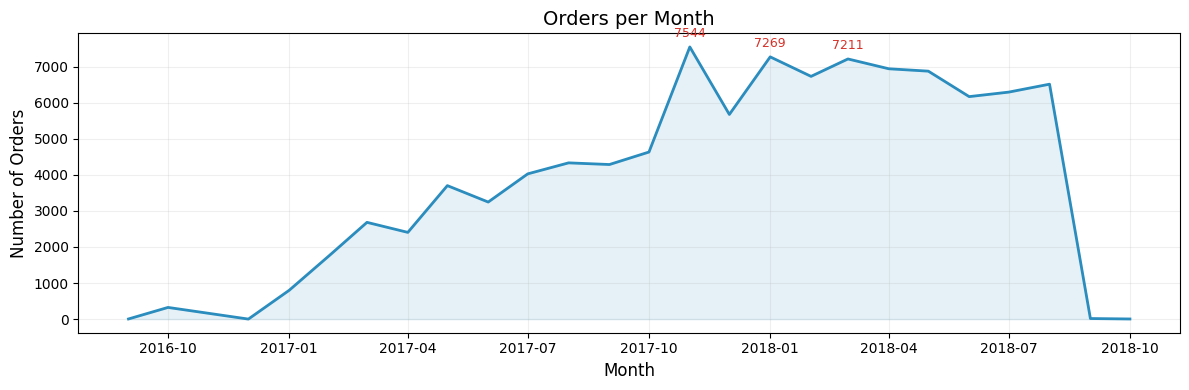

In [24]:

# Expecting a dataframe named `orders` with order_purchase_timestamp; if not present, try to load common file
try:
    orders
except NameError:
    import os
    orders = pd.read_csv(os.path.join('/mnt/data','olist_orders_dataset.csv'), parse_dates=['order_purchase_timestamp'], low_memory=False)

# prepare monthly series
orders['order_month'] = orders['order_purchase_timestamp'].dt.to_period('M').dt.to_timestamp()
monthly = orders.groupby('order_month').size().rename('n_orders').reset_index()

plt.figure(figsize=(12,4))
plt.plot(monthly['order_month'], monthly['n_orders'], color=PALETTE[0], linewidth=2)
plt.fill_between(monthly['order_month'], monthly['n_orders'], alpha=0.12, color=PALETTE[0])
plt.title('Orders per Month')
plt.xlabel('Month')
plt.ylabel('Number of Orders')
# annotate top 3 peaks
top = monthly.nlargest(3, 'n_orders')
for _, row in top.iterrows():
    plt.annotate(int(row['n_orders']), xy=(row['order_month'], row['n_orders']), xytext=(0,7), textcoords='offset points', ha='center', fontsize=9, color=PALETTE[3])
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()


## Delivery time distribution
Compute delivery_time_days and visualize distribution (histogram + boxplot).  
**Inference:** Skew and outliers indicate delivery issues; investigate tails.

Count with delivery time: 96476


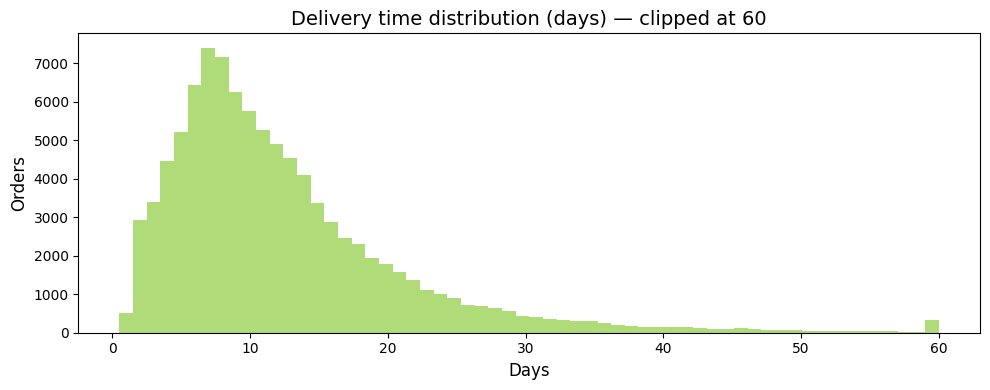

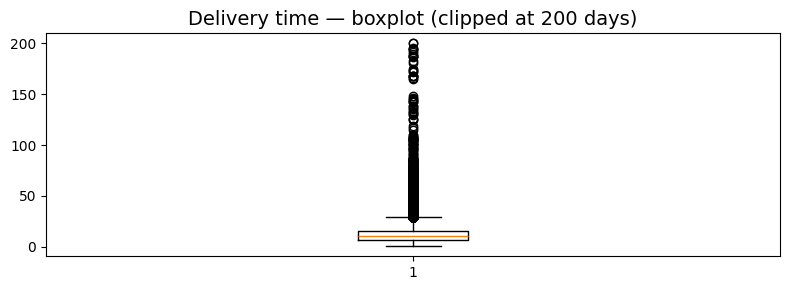

In [25]:

# Compute delivery time if not present
try:
    orders_dt
except NameError:
    orders_dt = orders.copy()
    orders_dt['order_delivered_customer_date'] = pd.to_datetime(orders_dt['order_delivered_customer_date'], errors='coerce')
    orders_dt['order_purchase_timestamp'] = pd.to_datetime(orders_dt['order_purchase_timestamp'], errors='coerce')
    orders_dt = orders_dt[orders_dt['order_delivered_customer_date'].notna() & orders_dt['order_purchase_timestamp'].notna()].copy()
    orders_dt['delivery_time_days'] = (orders_dt['order_delivered_customer_date'] - orders_dt['order_purchase_timestamp']).dt.total_seconds()/(3600*24)

vals = orders_dt['delivery_time_days'].dropna()
print('Count with delivery time:', len(vals))
plt.figure(figsize=(10,4))
plt.hist(vals.clip(upper=60), bins=60, color=PALETTE[1], alpha=0.9)
plt.title('Delivery time distribution (days) — clipped at 60')
plt.xlabel('Days')
plt.ylabel('Orders')
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,3))
plt.boxplot(vals.dropna().clip(upper=200))
plt.title('Delivery time — boxplot (clipped at 200 days)')
plt.tight_layout()
plt.show()


## Reviews vs Delivery Time
Scatter plot with LOWESS smoothing to show how delivery speed correlates with review scores.

**Inference:** If trend falls, longer delivery likely harms satisfaction.

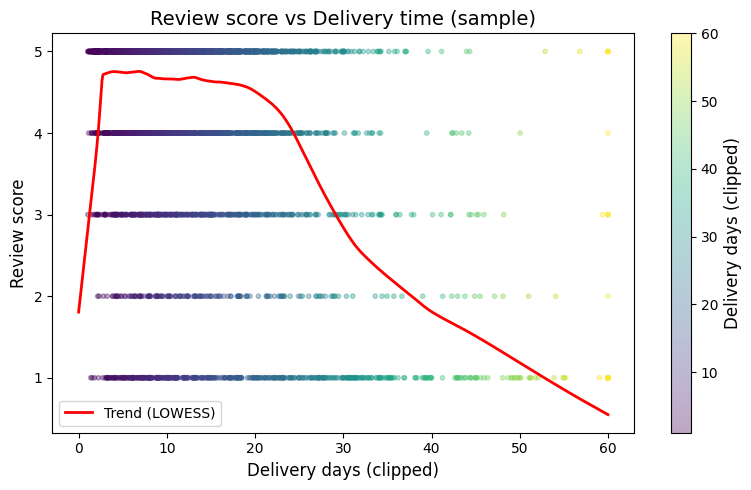

In [26]:

# load reviews if not present
try:
    reviews
except NameError:
    reviews = pd.read_csv('/mnt/data/olist_order_reviews_dataset.csv', parse_dates=['review_creation_date'], low_memory=False)

rev_ord = reviews.merge(orders_dt[['order_id','delivery_time_days']], on='order_id', how='left')
sample = rev_ord.sample(n=5000, random_state=42) if len(rev_ord)>5000 else rev_ord.copy()

plt.figure(figsize=(8,5))
plt.scatter(sample['delivery_time_days'].clip(upper=60), sample['review_score'], alpha=0.35, s=10, c=sample['delivery_time_days'].clip(upper=60), cmap='viridis')
plt.colorbar(label='Delivery days (clipped)')
# LOWESS trend
try:
    from statsmodels.nonparametric.smoothers_lowess import lowess
    x = sample['delivery_time_days'].clip(upper=60).fillna(0)
    y = sample['review_score'].fillna(sample['review_score'].median())
    z = lowess(y, x, frac=0.2)
    plt.plot(z[:,0], z[:,1], color='red', linewidth=2, label='Trend (LOWESS)')
    plt.legend()
except Exception as e:
    print('LOWESS unavailable:', e)
plt.xlabel('Delivery days (clipped)'); plt.ylabel('Review score')
plt.title('Review score vs Delivery time (sample)')
plt.tight_layout()
plt.show()


## Top product categories by revenue
Gradient bars with annotations help identify revenue drivers.  
**Inference:** Focus inventory and promotions on top categories.

/tmp/ipython-input-118305412.py:23: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = mpl.cm.get_cmap('YlOrBr')


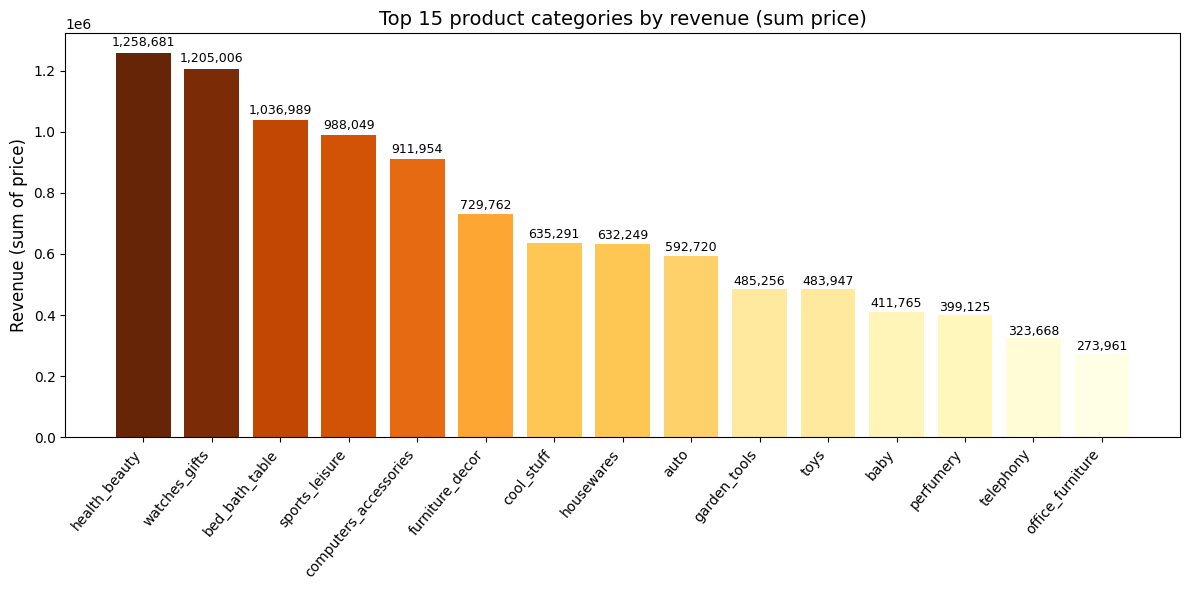

In [27]:

# load products, categories, order_items if needed
try:
    products
except NameError:
    products = pd.read_csv('/mnt/data/olist_products_dataset.csv', low_memory=False)
try:
    categories
except NameError:
    categories = pd.read_csv('/mnt/data/product_category_name_translation.csv', low_memory=False)
try:
    order_items
except NameError:
    order_items = pd.read_csv('/mnt/data/olist_order_items_dataset.csv', low_memory=False)

prod_cat = products.merge(categories, on='product_category_name', how='left')
oi_prod = order_items.merge(prod_cat[['product_id','product_category_name_english']], on='product_id', how='left')
cat_revenue = oi_prod.groupby('product_category_name_english')['price'].sum().reset_index().sort_values('price', ascending=False).head(15)

vals = cat_revenue['price'].values
labels = cat_revenue['product_category_name_english'].astype(str).values
import matplotlib as mpl
norm = mpl.colors.Normalize(vmin=vals.min(), vmax=vals.max())
cmap = mpl.cm.get_cmap('YlOrBr')

plt.figure(figsize=(12,6))
bars = plt.bar(labels, vals, color=cmap(norm(vals)))
plt.xticks(rotation=50, ha='right')
plt.title('Top 15 product categories by revenue (sum price)')
plt.ylabel('Revenue (sum of price)')
for bar in bars:
    h = bar.get_height()
    plt.text(bar.get_x()+bar.get_width()/2, h+0.01*h, f"{h:,.0f}", ha='center', va='bottom', fontsize=9)
plt.tight_layout()
plt.show()


## Review text wordcloud
A visual summary of frequent words in reviews. If `wordcloud` is not installed, a top-words bar chart is shown instead.

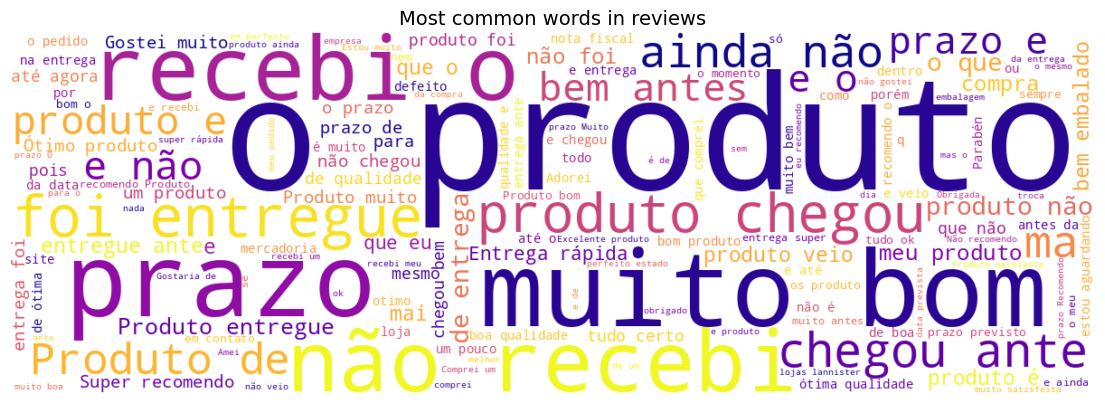

In [28]:

# Build wordcloud from review_comment_message
try:
    text = " ".join(str(s) for s in reviews['review_comment_message'].dropna().values)
    from wordcloud import WordCloud, STOPWORDS
    stopwords = set(STOPWORDS)
    wc = WordCloud(width=1200, height=400, background_color='white', stopwords=stopwords, max_words=150, colormap='plasma').generate(text)
    plt.figure(figsize=(14,5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title('Most common words in reviews')
    plt.show()
except Exception as e:
    print('WordCloud failed or not installed:', e)
    # fallback: top words bar
    from collections import Counter
    import re
    words = re.findall(r"\w+", text.lower())
    stop = set(['the','and','to','a','is','it','of','i','for','this','that','in','was','with','my','but','are','on','not','have','you','be','they'])
    words = [w for w in words if len(w)>2 and w not in stop]
    top = Counter(words).most_common(20)
    words_, counts_ = zip(*top)
    plt.figure(figsize=(10,5))
    plt.barh(words_[::-1], counts_[::-1], color=PALETTE[2])
    plt.title('Top words in reviews (fallback)')
    plt.tight_layout()
    plt.show()


## Geolocation: aggregation, distances, and maps
Aggregate zip-level coordinates; compute seller→customer distances; show static scatter and an interactive folium heatmap.

**Inference:** use these maps to understand delivery geography and spot long-distance deliveries.

Reduced geolocation rows: (19015, 3)
Distance stats (km):


,seller_customer_distance_km
count,98175.000000
mean,601.557004
std,595.586171
min,0.000000
25%,184.569131
50%,433.742859
75%,799.184795
max,8677.859564


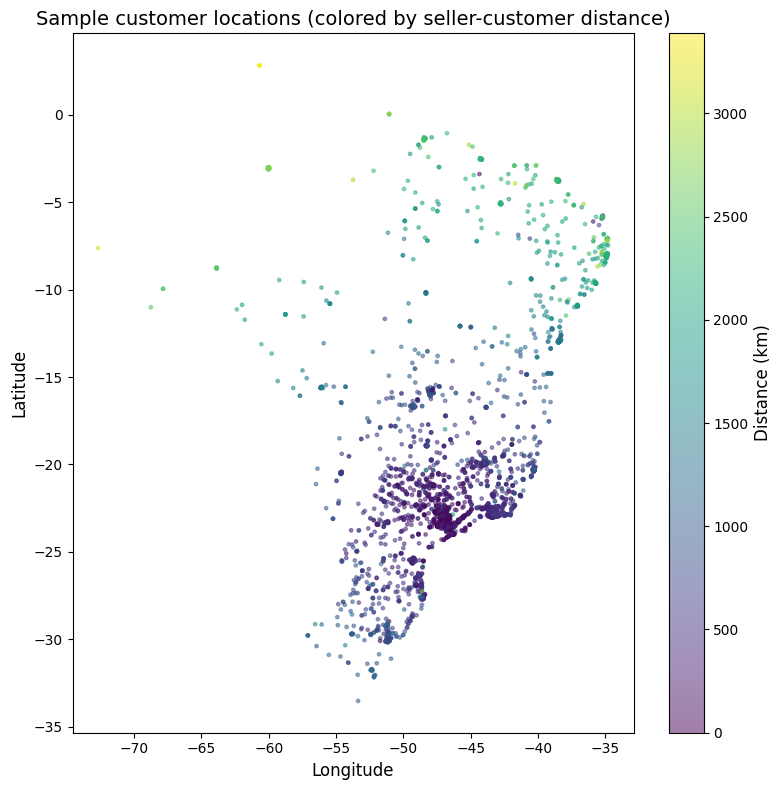

In [29]:

# Load geolocation and sellers/customers if needed
try:
    geoloc
except NameError:
    geoloc = pd.read_csv('/mnt/data/olist_geolocation_dataset.csv', low_memory=False)
try:
    sellers
except NameError:
    sellers = pd.read_csv('/mnt/data/olist_sellers_dataset.csv', low_memory=False)
try:
    customers
except NameError:
    customers = pd.read_csv('/mnt/data/olist_customers_dataset.csv', low_memory=False)

# Reduce geolocation to median lat/lng per zip prefix
geo_red = geoloc.groupby('geolocation_zip_code_prefix', as_index=False).agg({'geolocation_lat':'median','geolocation_lng':'median'})
geo_red = geo_red.rename(columns={'geolocation_zip_code_prefix':'zip_code_prefix','geolocation_lat':'lat','geolocation_lng':'lng'})
print('Reduced geolocation rows:', geo_red.shape)

# Map customer and seller prefix to coords
cust_loc = customers[['customer_id','customer_zip_code_prefix']].merge(geo_red, left_on='customer_zip_code_prefix', right_on='zip_code_prefix', how='left').rename(columns={'lat':'cust_lat','lng':'cust_lng'}).drop(columns=['zip_code_prefix'])
seller_loc = sellers[['seller_id','seller_zip_code_prefix']].merge(geo_red, left_on='seller_zip_code_prefix', right_on='zip_code_prefix', how='left').rename(columns={'lat':'seller_lat','lng':'seller_lng'}).drop(columns=['zip_code_prefix'])

# Build orders_geo (one seller per order - first seller) and compute distances
order_seller = order_items.groupby('order_id', as_index=False)['seller_id'].first()
orders_geo = orders[['order_id','customer_id']].merge(order_seller, on='order_id', how='left')
orders_geo = orders_geo.merge(cust_loc, on='customer_id', how='left').merge(seller_loc, on='seller_id', how='left')

# haversine
def haversine_np(lat1, lon1, lat2, lon2):
    R = 6371.0
    phi1 = np.radians(lat1.astype(float))
    phi2 = np.radians(lat2.astype(float))
    dphi = np.radians((lat2 - lat1).astype(float))
    dlambda = np.radians((lon2 - lon1).astype(float))
    a = np.sin(dphi / 2.0)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(dlambda / 2.0)**2
    return 2 * R * np.arcsin(np.sqrt(a))

mask = orders_geo['cust_lat'].notna() & orders_geo['seller_lat'].notna()
orders_geo['seller_customer_distance_km'] = np.nan
orders_geo.loc[mask, 'seller_customer_distance_km'] = haversine_np(orders_geo.loc[mask,'cust_lat'], orders_geo.loc[mask,'cust_lng'], orders_geo.loc[mask,'seller_lat'], orders_geo.loc[mask,'seller_lng'])

print('Distance stats (km):')
display(orders_geo['seller_customer_distance_km'].describe())

# Static scatter sample
import matplotlib.pyplot as plt
plt.figure(figsize=(8,8))
sample = orders_geo.dropna(subset=['cust_lat','cust_lng']).sample(n=min(5000, len(orders_geo.dropna(subset=['cust_lat','cust_lng']))), random_state=42)
plt.scatter(sample['cust_lng'], sample['cust_lat'], s=6, alpha=0.5, c=sample['seller_customer_distance_km'], cmap='viridis')
plt.colorbar(label='Distance (km)')
plt.xlabel('Longitude'); plt.ylabel('Latitude')
plt.title('Sample customer locations (colored by seller-customer distance)')
plt.tight_layout()
plt.show()


In [30]:

# Folium heatmap (interactive) - may render in notebooks
try:
    import folium
    from folium.plugins import HeatMap
    center_lat = np.nanmedian(orders_geo['cust_lat'])
    center_lng = np.nanmedian(orders_geo['cust_lng'])
    m = folium.Map(location=[center_lat, center_lng], zoom_start=5)
    heat_data = orders_geo[['cust_lat','cust_lng']].dropna().values.tolist()
    HeatMap(heat_data[:20000], radius=8, blur=10, max_zoom=10).add_to(m)  # limit points for performance
    m
except Exception as e:
    print('Folium not available or failed:', e)


## Correlation heatmap (selected features)
Shows pairwise correlations among key numeric variables.


Generating Correlation Heatmap...


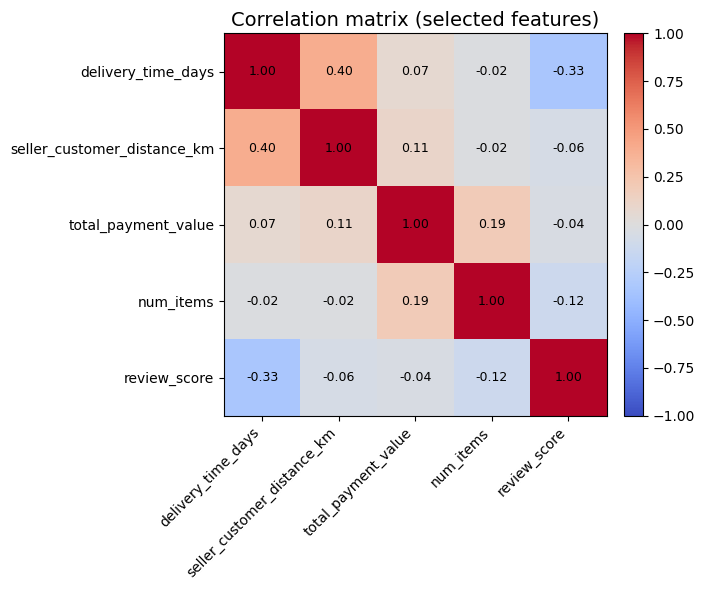

In [32]:
# --- Correlation heatmap (selected features) ---
print("\nGenerating Correlation Heatmap...")

num_cols = ['delivery_time_days','seller_customer_distance_km','total_payment_value','num_items','review_score']

# Use the already created df_master which contains all necessary columns
df_for_corr = df_master.copy()

# Ensure selected columns exist in df_master before proceeding
missing_cols = [col for col in num_cols if col not in df_for_corr.columns]
if missing_cols:
    print(f"Error: The following columns are missing from df_master: {missing_cols}. Cannot generate correlation matrix.")
else:
    corr = df_for_corr[num_cols].corr()
    import matplotlib.pyplot as plt
    plt.figure(figsize=(7,6))
    im = plt.imshow(corr, cmap='coolwarm', vmin=-1, vmax=1)
    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.xticks(range(len(num_cols)), num_cols, rotation=45, ha='right')
    plt.yticks(range(len(num_cols)), num_cols)
    # Add correlation values to the heatmap
    for (i, j), val in __import__('numpy').ndenumerate(corr.values):
        plt.text(j, i, f"{val:.2f}", ha='center', va='center', color='black', fontsize=9)
    plt.title('Correlation matrix (selected features)')
    plt.tight_layout()
    plt.show()